In [1]:
import os
from datasets import load_dataset
from segment.create_dataset import CreateSegmentationDataset, filter_list_in_column
from segment.utils import load_resize_image

In [2]:
# def transform_image(example):
#     example["image"] = load_resize_image(example["image"], 1024)
#     return example


# ds = ds.map(transform_image)
# ds = ds.shuffle().take(2)
# p = CreateSegmentationDataset(ds, text_prompt, bs=64, sub_bs=1)
# p.process()

In [3]:
# from datasets import Dataset

# def filter_rows_of_dataset(dataset: Dataset, filter_function):
#     """
#     Apply a filter function to the rows of a dataset.

#     :param dataset: The input dataset
#     :param filter_function: A function that takes a dictionary and returns True to keep it, False to filter it out
#     :return: A new dataset with filtered rows
#     """

#     return dataset.filter(filter_function)


# # remove any items from the md lists that are empty
# def remove_none(item):
#     return bool(item['metadata'])


# p.processed_ds = filter_rows_of_dataset(p.processed_ds, remove_none)

In [4]:
# p.check_results()

In [5]:
import yaml

class SegmentTrain:
    def __init__(self):
        pass

    def create_yolo_config(self, save_path: str):
        """Create and save the YOLO config YAML file."""
        config = {"names": {i: label for label, i in self.labels_dict.items()}}
        with open(save_path, "w") as file:
            yaml.dump(config, file)

In [6]:
from datasets import Dataset
from typing import Union, List
from segment.visualizer import visualizer

class Segment(CreateSegmentationDataset):
    def __init__(self, ds: Dataset, text_prompt: Union[List, str]):
        super().__init__(ds, text_prompt)
        self.ds = ds
        self.text_prompt = text_prompt
    
    def display(self, row=0):
        row = self.processed_ds[row]
        image = row['image']
        metadata = row['metadata']
        
        if not bool(metadata):
            raise ValueError("No metadata found for this image")
        
        visualizer(image, metadata, prompt_label='label')
        
    

In [7]:
image_dir = "datasets/fashion_people_detection/images/val"

ds = load_dataset("imagefolder", data_dir=image_dir, split="train")
text_prompt = ["face", "glasses", "clothes"]

ds = ds.shuffle().take(3)

seg = Segment(ds, text_prompt)

In [8]:
seg.process()

Processing Batches:   0%|          | 0/1 [00:00<?, ?batch/s]

Processing Images:   0%|          | 0/3 [00:00<?, ?img/s]

final text_encoder_type: bert-base-uncased
Model loading result: _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])
One Image had an error: 'NoneType' object is not iterable


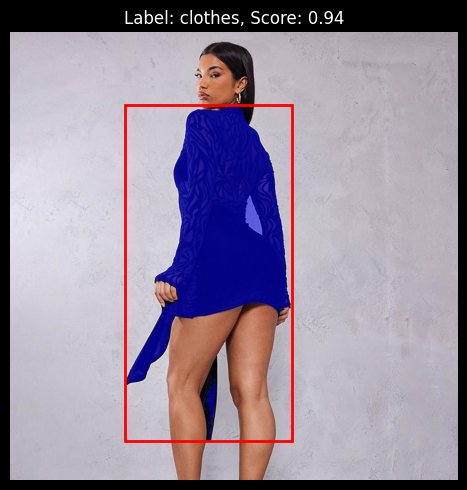

In [13]:
seg.display(row=0)